## Fonction NCC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import correlate
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Fonction MSE (Mean Squared Error)
def mse(spectrum_ref, spectrum_aligned):
    return np.mean((spectrum_ref - spectrum_aligned) ** 2)

# Fonction PSNR (Peak Signal-to-Noise Ratio)
def psnr(spectrum_ref, spectrum_aligned):
    mse_value = mse(spectrum_ref, spectrum_aligned)
    max_pixel = np.max(spectrum_ref)
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

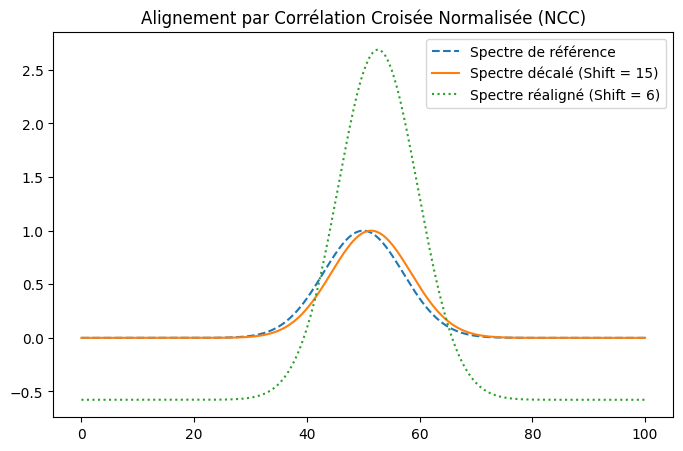

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

def ncc_alignment(spectrum_ref, spectrum_shifted):
    """
    Aligne un spectre décalé par corrélation croisée normalisée (NCC).
    
    Paramètres :
    - spectrum_ref : np.array, spectre de référence
    - spectrum_shifted : np.array, spectre à aligner
    
    Retourne :
    - best_shift : int, décalage optimal trouvé
    - spectrum_aligned : np.array, spectre corrigé
    """

    # Normalisation des spectres (moyenne 0, écart-type 1)
    spectrum_ref = (spectrum_ref - np.mean(spectrum_ref)) / np.std(spectrum_ref)
    spectrum_shifted = (spectrum_shifted - np.mean(spectrum_shifted)) / np.std(spectrum_shifted)

    # Calcul de la corrélation croisée normalisée
    correlation = correlate(spectrum_shifted, spectrum_ref, mode="full")
    lags = np.arange(-len(spectrum_ref) + 1, len(spectrum_ref))

    # Trouver le décalage optimal (max de la corrélation)
    best_shift = lags[np.argmax(correlation)]
    
    # Décaler le spectre pour le réaligner
    spectrum_aligned = np.roll(spectrum_shifted, best_shift)

    return best_shift, spectrum_aligned

# Génération de spectres synthétiques
x = np.linspace(0, 100, 500)  # Axe des longueurs d'onde
spectrum_ref = np.exp(-0.01*(x-50)**2)  # Raie gaussienne centrée sur x=50
spectrum_shifted = np.roll(spectrum_ref, 7)  # Décalage simulé de 7 pixels

# Application de l'algorithme NCC
best_shift, spectrum_aligned = ncc_alignment(spectrum_ref, spectrum_shifted)

# Affichage des spectres
plt.figure(figsize=(8, 5))
plt.plot(x, spectrum_ref, label="Spectre de référence", linestyle="dashed")
plt.plot(x, spectrum_shifted, label=f"Spectre décalé (Shift = 15)")
plt.plot(x, spectrum_aligned, label=f"Spectre réaligné (Shift = {best_shift})", linestyle="dotted")
plt.legend()
plt.title("Alignement par Corrélation Croisée Normalisée (NCC)")
plt.show()


## Distance Euclidian Alignement

In [3]:
def euclidean_alignment(spectrum_ref, spectrum_shifted):
    """
    Aligne un spectre en minimisant la distance euclidienne.
    
    Paramètres :
    - spectrum_ref : np.array, spectre de référence
    - spectrum_shifted : np.array, spectre à aligner
    
    Retourne :
    - best_shift : int, décalage optimal trouvé
    - spectrum_aligned : np.array, spectre corrigé
    """
    
    # Normalisation
    spectrum_ref = (spectrum_ref - np.mean(spectrum_ref)) / np.std(spectrum_ref)
    spectrum_shifted = (spectrum_shifted - np.mean(spectrum_shifted)) / np.std(spectrum_shifted)
    
    # Initialiser les variables
    best_shift = 0
    min_distance = float('inf')
    
    # Chercher le décalage qui minimise la distance euclidienne
    for shift in range(-len(spectrum_ref) + 1, len(spectrum_ref)):
        shifted_spectrum = np.roll(spectrum_shifted, shift)
        distance = np.linalg.norm(spectrum_ref - shifted_spectrum)
        
        if distance < min_distance:
            min_distance = distance
            best_shift = shift
    
    # Décalage optimal et spectre réaligné
    spectrum_aligned = np.roll(spectrum_shifted, best_shift)
    return best_shift, spectrum_aligned


## DTW (Dynamic Time Warping)

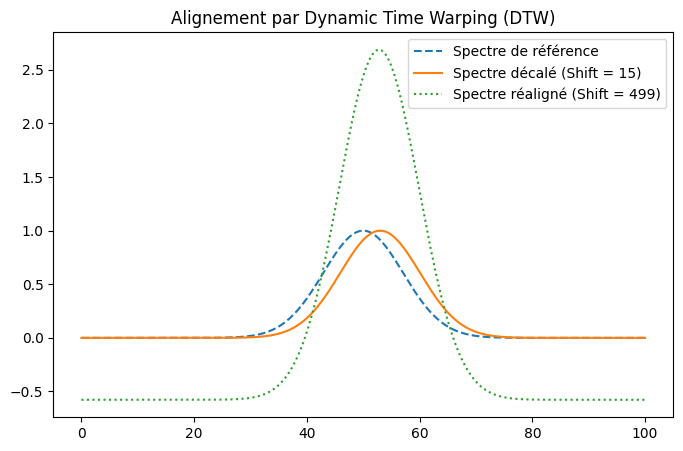

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def dtw_alignment(spectrum_ref, spectrum_shifted):
    """
    Aligne un spectre à l'aide du Dynamic Time Warping.
    
    Paramètres :
    - spectrum_ref : np.array, spectre de référence
    - spectrum_shifted : np.array, spectre à aligner
    
    Retourne :
    - best_shift : int, décalage optimal trouvé
    - spectrum_aligned : np.array, spectre corrigé
    """
    
    # Normalisation des spectres (moyenne 0, écart-type 1)
    spectrum_ref = (spectrum_ref - np.mean(spectrum_ref)) / np.std(spectrum_ref)
    spectrum_shifted = (spectrum_shifted - np.mean(spectrum_shifted)) / np.std(spectrum_shifted)
    
    # Calcul de la matrice de coût DTW
    n = len(spectrum_ref)
    dtw_matrix = np.zeros((n, n))
    
    # Remplissage de la première colonne et ligne
    dtw_matrix[0, 0] = abs(spectrum_ref[0] - spectrum_shifted[0])
    
    for i in range(1, n):
        dtw_matrix[i, 0] = dtw_matrix[i-1, 0] + abs(spectrum_ref[i] - spectrum_shifted[0])
        dtw_matrix[0, i] = dtw_matrix[0, i-1] + abs(spectrum_ref[0] - spectrum_shifted[i])
    
    # Remplissage de la matrice DTW
    for i in range(1, n):
        for j in range(1, n):
            cost = abs(spectrum_ref[i] - spectrum_shifted[j])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

    # Rechercher le chemin de coût minimal
    best_shift = np.argmin(dtw_matrix[-1])
    
    # Décalage du spectre pour obtenir l'alignement
    spectrum_aligned = np.roll(spectrum_shifted, best_shift)
    
    return best_shift, spectrum_aligned

# Génération de spectres synthétiques
x = np.linspace(0, 100, 500)  # Axe des longueurs d'onde
spectrum_ref = np.exp(-0.01*(x-50)**2)  # Raie gaussienne centrée sur x=50
spectrum_shifted = np.roll(spectrum_ref, 15)  # Décalage simulé de 15 pixels

# Application de l'algorithme DTW
best_shift, spectrum_aligned = dtw_alignment(spectrum_ref, spectrum_shifted)

# Affichage des spectres
plt.figure(figsize=(8, 5))
plt.plot(x, spectrum_ref, label="Spectre de référence", linestyle="dashed")
plt.plot(x, spectrum_shifted, label=f"Spectre décalé (Shift = 15)")
plt.plot(x, spectrum_aligned, label=f"Spectre réaligné (Shift = {best_shift})", linestyle="dotted")
plt.legend()
plt.title("Alignement par Dynamic Time Warping (DTW)")
plt.show()




## FastDTW Alignement

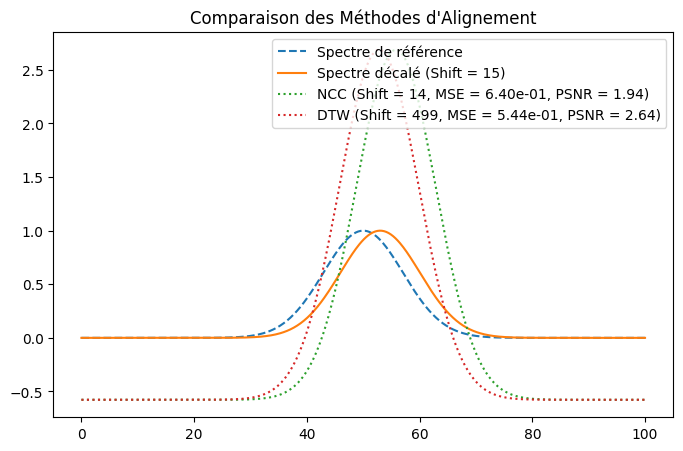

Temps d'exécution pour NCC : 0.0004 secondes
Temps d'exécution pour DTW : 0.1021 secondes


In [5]:
import time



# Génération de spectres synthétiques
x = np.linspace(0, 100, 500)
spectrum_ref = np.exp(-0.01*(x-50)**2)  # Raie gaussienne centrée sur x=50
spectrum_shifted = np.roll(spectrum_ref, 15)  # Décalage simulé de 15 pixels

# Mesure du temps pour NCC
start_time = time.time()
best_shift_ncc, spectrum_aligned_ncc = ncc_alignment(spectrum_ref, spectrum_shifted)
ncc_time = time.time() - start_time

# Mesure du temps pour DTW
start_time = time.time()
best_shift_dtw, spectrum_aligned_dtw = dtw_alignment(spectrum_ref, spectrum_shifted)
dtw_time = time.time() - start_time



# Calcul des métriques MSE et PSNR pour chaque méthode
mse_ncc = mse(spectrum_ref, spectrum_aligned_ncc)
psnr_ncc = psnr(spectrum_ref, spectrum_aligned_ncc)

mse_dtw = mse(spectrum_ref, spectrum_aligned_dtw)
psnr_dtw = psnr(spectrum_ref, spectrum_aligned_dtw)



# Affichage des résultats
plt.figure(figsize=(8, 5))
plt.plot(x, spectrum_ref, label="Spectre de référence", linestyle="dashed")
plt.plot(x, spectrum_shifted, label=f"Spectre décalé (Shift = 15)")
plt.plot(x, spectrum_aligned_ncc, label=f"NCC (Shift = {best_shift_ncc}, MSE = {mse_ncc:.2e}, PSNR = {psnr_ncc:.2f})", linestyle="dotted")
plt.plot(x, spectrum_aligned_dtw, label=f"DTW (Shift = {best_shift_dtw}, MSE = {mse_dtw:.2e}, PSNR = {psnr_dtw:.2f})", linestyle="dotted")
plt.legend()
plt.title("Comparaison des Méthodes d'Alignement")
plt.show()

# Affichage des temps de calcul
print(f"Temps d'exécution pour NCC : {ncc_time:.4f} secondes")
print(f"Temps d'exécution pour DTW : {dtw_time:.4f} secondes")


## Transformation Fourier

In [6]:
def fourier_alignment(spectrum_ref, spectrum_shifted):
    """
    Aligne un spectre en utilisant la transformée de Fourier.
    
    Paramètres :
    - spectrum_ref : np.array, spectre de référence
    - spectrum_shifted : np.array, spectre à aligner
    
    Retourne :
    - best_shift : int, décalage optimal trouvé
    - spectrum_aligned : np.array, spectre corrigé
    """
    
    # Calcul des transformées de Fourier des spectres
    spectrum_ref_fft = np.fft.fft(spectrum_ref)
    spectrum_shifted_fft = np.fft.fft(spectrum_shifted)
    
    # Calcul de la corrélation croisée dans le domaine de Fourier
    correlation = np.fft.ifft(np.conj(spectrum_ref_fft) * spectrum_shifted_fft)
    
    # Trouver le décalage optimal
    best_shift = np.argmax(np.abs(correlation))
    spectrum_aligned = np.roll(spectrum_shifted, best_shift)
    
    return best_shift, spectrum_aligned
